In [1]:
from torch.utils.data import Dataset, DataLoader, random_split # Dataset: Base class
import torch
import torchaudio
import torch.nn as nn
import numpy as np
import pywt

import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import copy

In [2]:
torch.manual_seed(10)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')

In [4]:
print('Device:',device)

Device: cpu


Now we need to register this GPU (if available) to -
- `transform` attribute in the Custom Dataset class below (which uses `torchaudio.transforms`)
- Tensor `waveform` in `__getitem__()` function

## Urban Sound 8K Custom Dataset

In [5]:
class UrbanSound8KDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, num_samples = None, transformation = None, target_sample_rate = 22050, device = 'cpu', wavelet = 'db4') -> None:
        super(UrbanSound8KDataset, self).__init__()
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir # Audio Directory
        self.target_sample_rate = target_sample_rate
        self.device = device
        self.wavelet = pywt.Wavelet(wavelet)
        if transformation is not None:
            self.transform = transformation.to(self.device)
        else:
            self.transform = None
        self.num_samples = num_samples

    def __len__(self): # len(usd) can be used - number of samples in the dataset
        return len(self.annotations) # Number of samples in the Dataset

    def __getitem__(self, index): # Subscriptable: o_list[1] --> o_list.__getitem__(1)
        # Loading the waveform of the audio associated to the index and also return the label with it
        audio_sample_path = self._get_audio_sample_path(index) # Starting with underscore function: Placeholder method
        label = self._get_audio_sample_label(index)
        waveform, sr = torchaudio.load(audio_sample_path)

        # Move the waveform to GPU if available
        waveform = waveform.to(self.device)

        # Make it mono (Since a signal can have multiple channels)
        waveform = self._mix_down_if_necessary(waveform)

        # Make all of the same sample rate (Since some audio data have different sample rate)
        waveform = self._resample_if_necessary(waveform, sr)

        # CUT or PAD the signal to the same number of samples = num_samples (Parameter passed when creating the object)
        if self.num_samples is not None:
            waveform = self._right_pad_if_necessary(waveform)
            waveform = self._cut_if_necessary(waveform)

        approx_coeffs = torch.tensor(pywt.dwt(waveform.numpy(), self.wavelet)[0]) # Using the APPROXIMATE COEFFICIENTS
        detail_coeffs = torch.tensor(pywt.dwt(waveform.numpy(), self.wavelet)[1]) # Using the DETAILED COEFFICIENTS

        # Applying mel spectrogram transformation to waveform
        if self.transform is not None:
            approx_coeffs = self.transform(approx_coeffs)
            detail_coeffs = self.transform(detail_coeffs)
        
        return approx_coeffs, detail_coeffs, label

    def _right_pad_if_necessary(self, waveform):
        length_signal = waveform.shape[1]
        if(length_signal < self.num_samples):
            num_missing_samples = self.num_samples - length_signal

            last_dimension_padding = (0, num_missing_samples) # (Left pad, Right pad) on LAST axis

            waveform = torch.nn.functional.pad(waveform, last_dimension_padding)
        return waveform

    def _cut_if_necessary(self, waveform):
        # waveform.shape --> Tensor --> (no. of channels = 1, no. of samples)
        if(waveform.shape[1] > self.num_samples):
            # E.g. is [1, 50000] --> [1, 22050]
            waveform = waveform[:, :self.num_samples] # All channels, but first num_samples samples will be used
        return waveform

    def _resample_if_necessary(self, waveform, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            waveform = resampler(waveform) # Callable object
        return waveform

    def _mix_down_if_necessary(self, waveform):
        """
            Here we take the mean of each channel IF it has more than 1 channel
            - This is the general way of converting a multi-channel signal to a mono signal
        """
        # waveform.shape --> (no. of channels, no. of samples)
        # First dimension determines the number of channels, as seen in the previous notebook as well, hence we set dim = 0
        # keepdims is for ensuring the waveform is still a RANK 2 tensor, and does not become RANK 1, when taking mean of all rows
        # If already mono, don't perform any operation

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

    def _get_audio_sample_path(self, index):
        folder = f"fold{self.annotations['fold'][index]}" # Folder number
        path = os.path.join(self.audio_dir, folder, self.annotations['slice_file_name'][index])
        return path
    
    def _get_audio_sample_label(self, index):
        return self.annotations['classID'][index]

In [6]:
annotations_file = '../../../Datasets/UrbanSound8K/metadata/UrbanSound8K.csv'
audio_dir = '../../../Datasets/UrbanSound8K/audio/'

## Fixing the **duration** of each example

In [7]:
sample_rate = 22050
num_samples = sample_rate*1 # Taking 1 second of each sample
hop_length = 256
wavelet = 'db3'

# Mel-Spectrogram

In [8]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate,
    n_fft = 2048,
    hop_length = hop_length,
    n_mels = 64 # Number of mel filter banks
)

In [9]:
usd = UrbanSound8KDataset(annotations_file, audio_dir, num_samples = num_samples, target_sample_rate = sample_rate, wavelet=wavelet, transformation=mel_spectrogram)

In [10]:
shape = usd[0][0].shape
shape

torch.Size([1, 64, 44])

In [11]:
shape = usd[1][0].shape
shape

torch.Size([1, 64, 44])

## Dataloader

In [12]:
train_data, test_data = random_split(usd, [0.9, 0.1])

In [13]:
batch_size = 256

In [14]:
train_loader = DataLoader(
    train_data, 
    batch_size = batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    test_data, 
    batch_size = batch_size, 
    shuffle=True
)

torch.Size([256, 1, 64, 44])
torch.Size([256, 1, 64, 44])


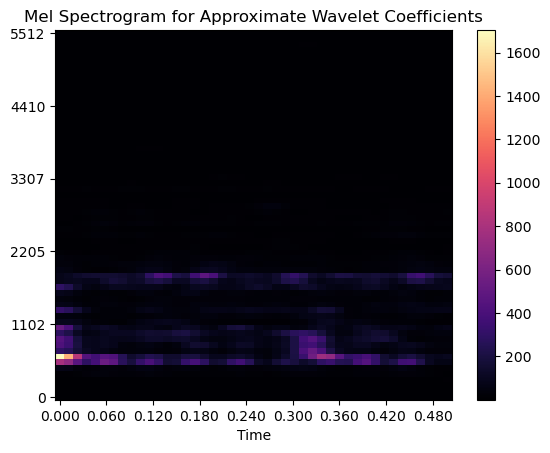

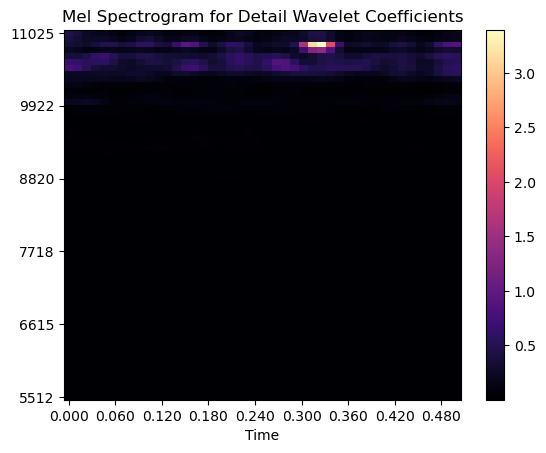

In [15]:
wavelet_approx_coeffs, detail_coeffs, label = next(iter(train_loader))
print(wavelet_approx_coeffs.shape)
print(detail_coeffs.shape)

plt.figure(1)
librosa.display.specshow(wavelet_approx_coeffs[0][0].numpy(), x_axis='time', y_coords=np.linspace(0,sample_rate/4,wavelet_approx_coeffs[0][0].numpy().shape[0]), hop_length=hop_length)
plt.yticks(np.linspace(0,sample_rate//4,6))
plt.title('Mel Spectrogram for Approximate Wavelet Coefficients')
plt.colorbar()

plt.figure(2)
librosa.display.specshow(detail_coeffs[0][0].numpy(), x_axis='time', y_coords=np.linspace(sample_rate/4,sample_rate/2,wavelet_approx_coeffs[0][0].numpy().shape[0]), hop_length=hop_length)
plt.yticks(np.linspace(sample_rate/4,sample_rate//2,6))
plt.title('Mel Spectrogram for Detail Wavelet Coefficients')
plt.colorbar()

# LSTM

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, device) -> None:
        super(LSTM, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

        self.lstm_a1 = nn.LSTMCell(input_size, hidden_size=hidden_size1)
        self.lstm_a2 = nn.LSTMCell(hidden_size1, hidden_size=hidden_size2)
        self.lstm_a3 = nn.LSTMCell(hidden_size2, hidden_size=hidden_size3)

        self.lstm_d1 = nn.LSTMCell(input_size, hidden_size=hidden_size1)
        self.lstm_d2 = nn.LSTMCell(hidden_size1, hidden_size=hidden_size2)
        self.lstm_d3 = nn.LSTMCell(hidden_size2, hidden_size=hidden_size3)

        self.linear = nn.Linear(hidden_size3*2, 10)

    def forward_lstm(self, x, approx_bool):
        batch_size = x.shape[0]
        ht1 = torch.zeros(batch_size, self.hidden_size1).to(self.device) # (16, 256)
        ct1 = torch.zeros(batch_size, self.hidden_size1).to(self.device) # (16, 256)
        ht2 = torch.zeros(batch_size, self.hidden_size2).to(self.device) # (16, 256)
        ct2 = torch.zeros(batch_size, self.hidden_size2).to(self.device) # (16, 256)
        ht3 = torch.zeros(batch_size, self.hidden_size3).to(self.device) # (16, 256)
        ct3 = torch.zeros(batch_size, self.hidden_size3).to(self.device) # (16, 256)

        if approx_bool == True:
            for input1 in x.split(1, dim = 3):
                input1 = input1.view(batch_size, -1)
                # print(input1.shape) # (16, 64) - where 64 is the number of samples in one mel spectrum (one column)
                (ht1, ct1) = self.lstm_a1(input1, (ht1, ct1))
                (ht2, ct2) = self.lstm_a2(ht1, (ht2, ct2))
                (ht3, ct3) = self.lstm_a3(ht2, (ht3, ct3))
        else:
            for input1 in x.split(1, dim = 3):
                input1 = input1.view(batch_size, -1)
                # print(input1.shape) # (16, 64) - where 64 is the number of samples in one mel spectrum (one column)
                (ht1, ct1) = self.lstm_d1(input1, (ht1, ct1))
                (ht2, ct2) = self.lstm_d2(ht1, (ht2, ct2))
                (ht3, ct3) = self.lstm_d3(ht2, (ht3, ct3))
        
        return ht3
    
    def forward(self, approx_coeffs, detail_coeffs):
        approx_coeffs = self.forward_lstm(approx_coeffs, True)
        detail_coeffs = self.forward_lstm(detail_coeffs, False)

        ht3 = torch.cat((approx_coeffs, detail_coeffs), 1)
        
        output = self.linear(ht3)
        return output

In [17]:
lstm = LSTM(input_size = usd[0][0].shape[1], hidden_size1=256, hidden_size2=512, hidden_size3=512, device = device).to(device)

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.7)
losses = []

In [19]:
num_epochs = 50

In [20]:
best_weights = copy.deepcopy(lstm.state_dict())
max = 0
val_acc = 0
train_acc = 0
for epoch in range(num_epochs):
    lstm.train()
    for i, (approx_coeffs, detail_coeffs, labels) in enumerate(train_loader):
        approx_coeffs = approx_coeffs.to(device)
        detail_coeffs = detail_coeffs.to(device)
        labels = labels.to(device)

        preds = lstm(approx_coeffs, detail_coeffs)
        loss = criterion(preds, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        lstm.eval()
        for approx_coeffs, detail_coeffs, labels in test_loader:
            approx_coeffs = approx_coeffs.to(device)
            detail_coeffs = detail_coeffs.to(device)
            labels = labels.to(device)
            pred_outputs1 = lstm(approx_coeffs, detail_coeffs)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(lstm.state_dict())

        n_samples = 0
        n_correct = 0
        
        if (epoch+1)%5 == 0:
            for approx_coeffs, detail_coeffs, labels in train_loader:
                approx_coeffs = approx_coeffs.to(device)
                detail_coeffs = detail_coeffs.to(device)
                labels = labels.to(device)
                pred_outputs1 = lstm(approx_coeffs, detail_coeffs)
                _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
                n_samples += labels.shape[0]
                n_correct += (actual_preds1 == labels).sum().item()
            train_acc = n_correct/n_samples * 100
            print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)

Epoch 1/50; Loss = 1.418363; LR = [0.002]
SAVED MODEL WEIGHTS
Dev Accuracy: 56.82%
--------------------
Epoch 2/50; Loss = 1.179090; LR = [0.002]
SAVED MODEL WEIGHTS
Dev Accuracy: 63.00%
--------------------
Epoch 3/50; Loss = 1.169362; LR = [0.002]
SAVED MODEL WEIGHTS
Dev Accuracy: 65.86%
--------------------
Epoch 4/50; Loss = 0.921836; LR = [0.002]
SAVED MODEL WEIGHTS
Dev Accuracy: 70.56%
--------------------
Epoch 5/50; Loss = 0.977916; LR = [0.002]
Train Accuracy: 76.89%
Dev Accuracy: 69.07%
--------------------
Epoch 6/50; Loss = 0.768970; LR = [0.0014]
Dev Accuracy: 68.96%
--------------------
Epoch 7/50; Loss = 0.619024; LR = [0.0014]
SAVED MODEL WEIGHTS
Dev Accuracy: 73.77%
--------------------
Epoch 8/50; Loss = 0.411417; LR = [0.0014]
SAVED MODEL WEIGHTS
Dev Accuracy: 73.88%
--------------------
Epoch 9/50; Loss = 0.543496; LR = [0.0014]
SAVED MODEL WEIGHTS
Dev Accuracy: 75.37%
--------------------
Epoch 10/50; Loss = 0.376447; LR = [0.0014]
SAVED MODEL WEIGHTS
Train Accurac

Finished Training in 

Text(0.5, 1.0, 'Loss vs Epochs')

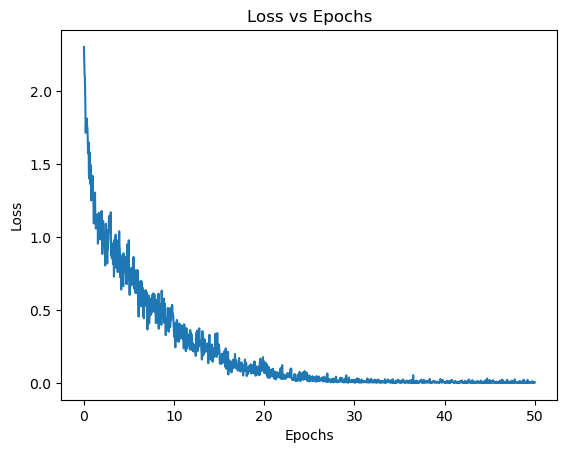

In [21]:
plt.plot(np.linspace(0,num_epochs,len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

## Prediction

In [23]:
lstm.load_state_dict(best_weights)

<All keys matched successfully>

In [24]:
lstm.eval()
n_samples=0
n_correct=0
for approx_coeffs, detail_coeffs, labels in train_loader: # Test Accuracy
    approx_coeffs = approx_coeffs.to(device)
    detail_coeffs = detail_coeffs.to(device)
    labels = labels.to(device)
    pred_outputs1 = lstm(approx_coeffs, detail_coeffs)
    _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
    n_samples += labels.shape[0]
    n_correct += (actual_preds1 == labels).sum().item()
train_acc = n_correct/n_samples * 100
print(f'Train Accuracy = {train_acc:.2f}%')

Train Accuracy = 99.59%


In [25]:
lstm.eval()
n_samples=0
n_correct=0
for approx_coeffs, detail_coeffs, labels in test_loader: # Test Accuracy
    approx_coeffs = approx_coeffs.to(device)
    detail_coeffs = detail_coeffs.to(device)
    labels = labels.to(device)
    pred_outputs1 = lstm(approx_coeffs, detail_coeffs)
    _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
    n_samples += labels.shape[0]
    n_correct += (actual_preds1 == labels).sum().item()
test_acc = n_correct/n_samples * 100
print(f'Test Accuracy = {test_acc:.2f}%')

Test Accuracy = 81.56%
